In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [30] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81]])

## Optimization Model 

In [5]:
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


In [6]:
# solve
ks_model.setObj([i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Obj: 265.0
40
43
44
45
46
47


In [7]:
# relax
ks_model_rel = ks_model.relax()

In [8]:
# solve
ks_model_rel.setObj([i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9225932025752352, 0.0, 0.0, 1.0, 0.6333283425662526, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
Obj: 281.10241054050005
37
40
41
43
45
46
47


## Data Loader 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [10]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [11]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.66it/s]


In [12]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 775.01it/s]


In [13]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.72it/s]


In [14]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [15]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [16]:
x.shape

torch.Size([32, 5])

In [17]:
c.shape

torch.Size([32, 48])

In [18]:
w.shape

torch.Size([32, 48])

In [19]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [22]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [23]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [24]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [25]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.62it/s]


Normalized Regret: 12.45%
Normalized Unambiguous Regret: 12.45%


In [26]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 1.53, 4.22, 1.01, 0.43, 1.73, 0.37, 1.77, 1.53, 0.90, 1.17, 4.08, 1.57, 0.99, 4.51, 2.95, 1.91, 1.86, 1.74, 3.12, 2.99, 1.30, 0.98, 1.57, 0.53, 3.14, 2.77, 2.31, 3.00, 1.26, 1.70, 1.55, 1.49, 3.77, 1.11, 3.58, 3.87, 1.37, 3.00, 3.01, 1.12, 1.64, 3.89, 1.39, 3.84, 2.86, 1.17, 3.84, 1.32
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0

## Two-Stage with Grid Search 

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [28]:
# build model
twostage_model = pyepo.twostage.sklearnPred(Ridge())

In [29]:
# creat scorer
spo_scorer = pyepo.metric.metrics.makeSkScorer(ks_model)

In [30]:
# build grid search
grid = GridSearchCV(twostage_model, param_grid={"estimator__alpha": [0, 0.1, 0.5]}, scoring=spo_scorer)

In [31]:
# training
grid.fit(ks_dataset_train.feats, ks_dataset_train.costs)

GridSearchCV(estimator=MultiOutputRegressor(estimator=Ridge()),
             param_grid={'estimator__alpha': [0, 0.1, 0.5]},
             scoring=make_scorer(SPOError, greater_is_better=False, model_type=<class 'pyepo.model.grb.knapsack.knapsackModel'>, args={'weights': array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81]]), 'capacity': array([30, 30])}))

In [32]:
# prediction
c_test_pred = grid.predict(ks_dataset_test.feats)

In [33]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.90it/s]


Normalized Regret: 12.49%
Normalized Unambiguous Regret: 12.49%


In [34]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = grid.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 1.55, 4.22, 1.03, 0.45, 1.74, 0.39, 1.78, 1.54, 0.91, 1.19, 4.08, 1.58, 1.01, 4.51, 2.95, 1.93, 1.87, 1.75, 3.13, 2.99, 1.31, 1.00, 1.58, 0.55, 3.14, 2.78, 2.32, 3.00, 1.27, 1.70, 1.57, 1.51, 3.77, 1.13, 3.58, 3.87, 1.38, 3.01, 3.01, 1.14, 1.64, 3.89, 1.40, 3.84, 2.87, 1.18, 3.84, 1.33
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0

## Linear Regression from PyTorch

In [35]:
from torch import nn

In [36]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [37]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [38]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [39]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [40]:
# train model
num_epochs = 100
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous regret 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), trueloss*100, unambloss*100))

Epoch   0, Loss:  43.8966, Regret: 47.9120%, Unambiguous Regret: 47.9120%
Epoch   5, Loss:  90.8322, Regret: 32.8828%, Unambiguous Regret: 32.8828%
Epoch  10, Loss:  28.7902, Regret: 23.6237%, Unambiguous Regret: 23.6237%
Epoch  15, Loss:  79.8637, Regret: 18.3183%, Unambiguous Regret: 18.3183%
Epoch  20, Loss:  58.5269, Regret: 15.4090%, Unambiguous Regret: 15.4090%
Epoch  25, Loss:  34.0693, Regret: 14.1099%, Unambiguous Regret: 14.1099%
Epoch  30, Loss:  29.2040, Regret: 13.1806%, Unambiguous Regret: 13.1806%
Epoch  35, Loss:  20.2083, Regret: 12.3199%, Unambiguous Regret: 12.3199%
Epoch  40, Loss:  37.3236, Regret: 12.1139%, Unambiguous Regret: 12.1139%
Epoch  45, Loss:  57.8363, Regret: 11.9805%, Unambiguous Regret: 11.9805%
Epoch  50, Loss:   8.6398, Regret: 11.8775%, Unambiguous Regret: 11.8775%
Epoch  55, Loss:  21.8147, Regret: 12.0108%, Unambiguous Regret: 12.0108%
Epoch  60, Loss:  29.2424, Regret: 12.2007%, Unambiguous Regret: 12.2007%
Epoch  65, Loss:  14.6942, Regret: 12.

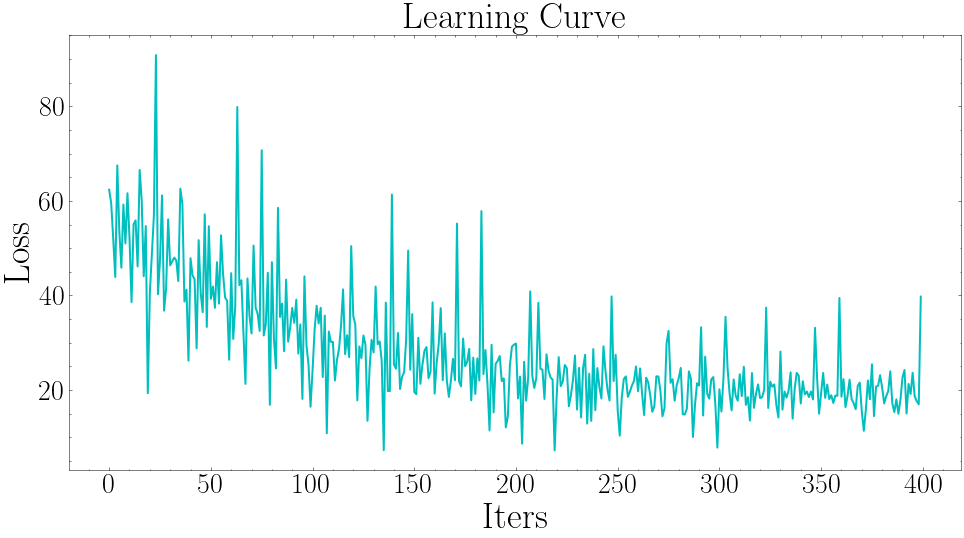

In [41]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

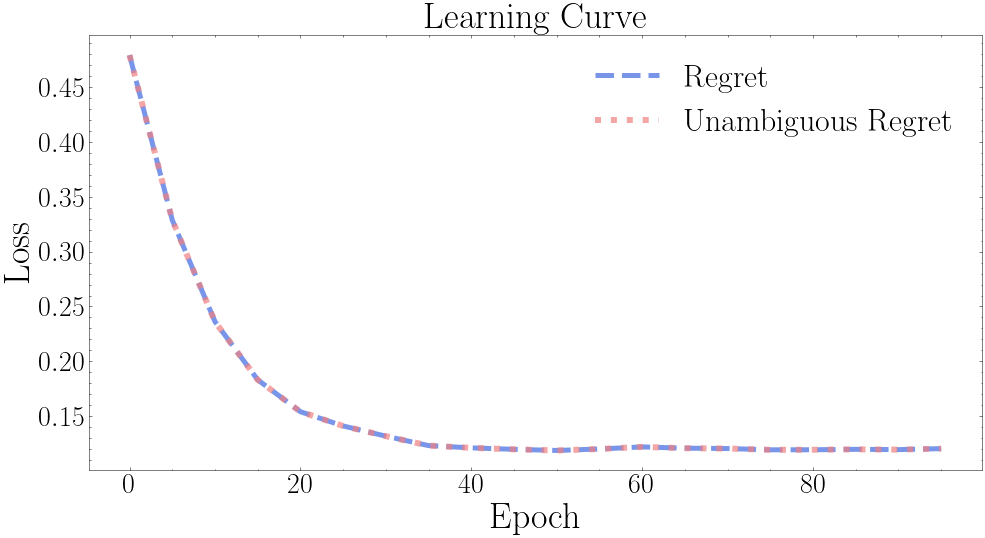

In [42]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [43]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 12.02%
Normalized Unambiguous Regret: 12.02%


In [44]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(-cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(-z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(-zpj))
        print()
    break

Sample 0:
    True cost: -2.00, -4.00, -1.00, -1.00, -2.00, -1.00, -2.00, -1.00, -1.00, -2.00, -5.00, -1.00, -1.00, -5.00, -3.00, -2.00, -1.00, -2.00, -3.00, -3.00, -1.00, -1.00, -1.00, -1.00, -3.00, -3.00, -2.00, -2.00, -1.00, -2.00, -2.00, -2.00, -3.00, -1.00, -4.00, -2.00, -1.00, -3.00, -4.00, -1.00, -2.00, -4.00, -1.00, -2.00, -3.00, -1.00, -5.00, -2.00
    Pred cost: 0.09, -2.78, 2.12, 1.44, 0.64, 2.39, -0.82, 0.13, 0.49, 1.17, -3.03, 0.19, 1.10, -3.13, -1.71, 0.62, -0.62, 0.57, -1.90, -0.43, 0.13, 2.18, 1.03, 1.60, -2.03, -2.19, -0.99, -2.07, 0.93, -0.43, 0.35, 0.92, -2.46, 1.14, -1.98, -2.06, -0.16, -1.23, -1.47, 1.50, -0.71, -2.92, 0.88, -1.68, -0.92, 0.19, -3.03, 1.09
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: -27.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

## SPO+ Rel 

In [45]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [46]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [47]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [48]:
# train model
num_epochs = 100
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous regret 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), trueloss*100, unambloss*100))

Epoch   0, Loss:  63.4950, Regret: 47.4352%, Unambiguous Regret: 47.4352%
Epoch   5, Loss:  38.1273, Regret: 31.5171%, Unambiguous Regret: 31.5171%
Epoch  10, Loss:  28.3715, Regret: 22.4640%, Unambiguous Regret: 22.4640%
Epoch  15, Loss:  28.5872, Regret: 18.2880%, Unambiguous Regret: 18.2880%
Epoch  20, Loss:  21.3364, Regret: 15.7181%, Unambiguous Regret: 15.7181%
Epoch  25, Loss:  31.8567, Regret: 14.1200%, Unambiguous Regret: 14.1200%
Epoch  30, Loss:  11.4233, Regret: 12.9281%, Unambiguous Regret: 12.9281%
Epoch  35, Loss:  48.7459, Regret: 12.0815%, Unambiguous Regret: 12.0815%
Epoch  40, Loss:  55.2145, Regret: 11.8492%, Unambiguous Regret: 11.8492%
Epoch  45, Loss:  16.1203, Regret: 11.8775%, Unambiguous Regret: 11.8775%
Epoch  50, Loss:  53.8897, Regret: 11.6249%, Unambiguous Regret: 11.6249%
Epoch  55, Loss:  10.2133, Regret: 11.5421%, Unambiguous Regret: 11.5421%
Epoch  60, Loss:  15.4961, Regret: 11.5260%, Unambiguous Regret: 11.5260%
Epoch  65, Loss:   8.3410, Regret: 11.

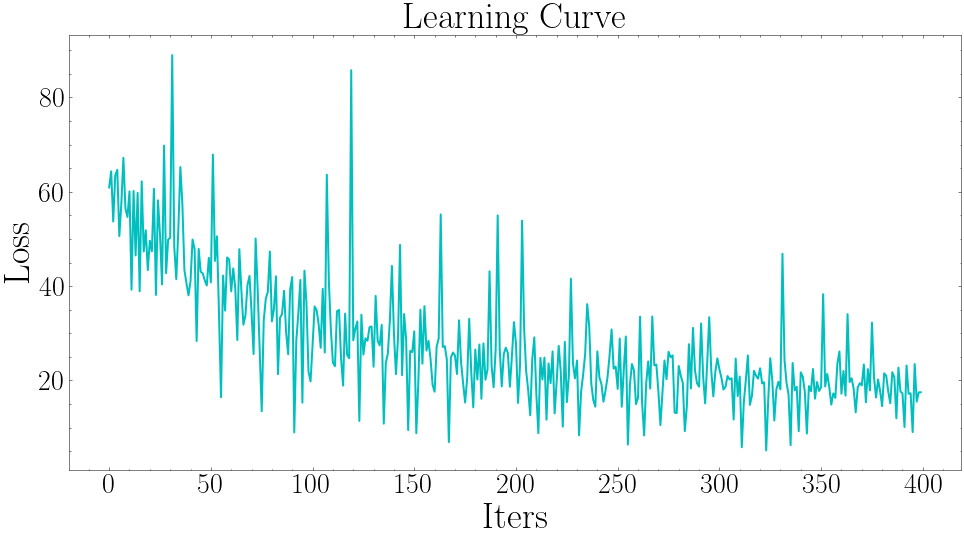

In [49]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

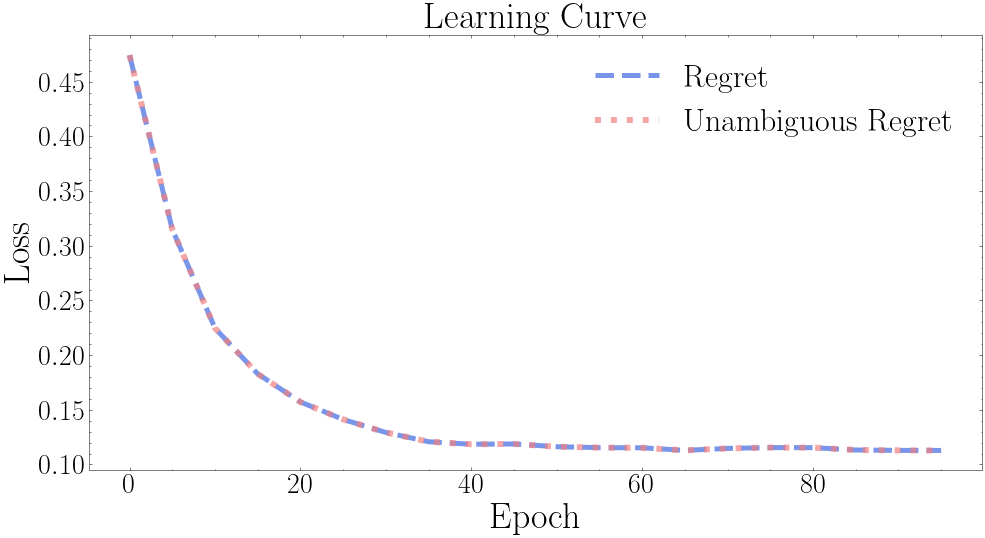

In [50]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [51]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 11.28%
Normalized Unambiguous Regret: 11.28%


In [52]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: -0.99, 3.00, -1.26, -2.22, -0.77, -3.10, 0.35, -0.25, -0.62, -1.59, 3.54, -0.03, -1.14, 3.15, 1.91, -0.63, 0.81, -0.41, 1.69, 0.79, -0.41, -1.39, -0.51, -1.91, 2.26, 1.48, 0.96, 1.93, -0.88, 0.04, -0.61, -1.13, 2.28, -1.39, 1.93, 2.18, -0.44, 1.49, 1.79, -1.48, -0.07, 2.97, -0.33, 2.29, 0.97, -0.37, 3.05, -0.44
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: 0, 0, 0, 0, 0, 0, -0, 0, 0, 0, 1, 0, 0, 1, 0, 0, -0, 0, 1, -0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -0, 0, 0, 1, 0, 0, 0, 0, 0, -0, 0, 0, 1, 

## Black-Box

In [53]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [54]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [55]:
# set loss
dbb = pyepo.func.blackboxOpt(ks_model, lambd=20, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [56]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    for para in reg.parameters():
        #print(para.data[:4,0])
        break
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = dbb(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(abs_grad)
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous regret 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), trueloss*100, unambloss*100))

Epoch   0, Loss:  26.0000, Regret: 51.5506%, Unambiguous Regret: 51.5506%
Epoch   5, Loss:  44.5000, Regret: 40.3923%, Unambiguous Regret: 40.3923%
Epoch  10, Loss:  19.7500, Regret: 33.1050%, Unambiguous Regret: 33.1050%
Epoch  15, Loss:   6.5000, Regret: 27.4259%, Unambiguous Regret: 27.4259%
Epoch  20, Loss:   7.7500, Regret: 24.6459%, Unambiguous Regret: 24.6459%
Epoch  25, Loss:   6.5000, Regret: 23.0479%, Unambiguous Regret: 23.0479%
Epoch  30, Loss:   8.7500, Regret: 21.6357%, Unambiguous Regret: 21.6357%
Epoch  35, Loss:  10.7500, Regret: 20.8457%, Unambiguous Regret: 20.8457%
Epoch  40, Loss:   6.0000, Regret: 20.3103%, Unambiguous Regret: 20.3103%
Epoch  45, Loss:   5.5000, Regret: 20.0780%, Unambiguous Regret: 20.0780%
Epoch  50, Loss:  10.7500, Regret: 19.9729%, Unambiguous Regret: 19.9729%
Epoch  55, Loss:  21.2500, Regret: 19.8760%, Unambiguous Regret: 19.8760%
Epoch  60, Loss:  13.0000, Regret: 19.8497%, Unambiguous Regret: 19.8497%
Epoch  65, Loss:   8.2500, Regret: 19.

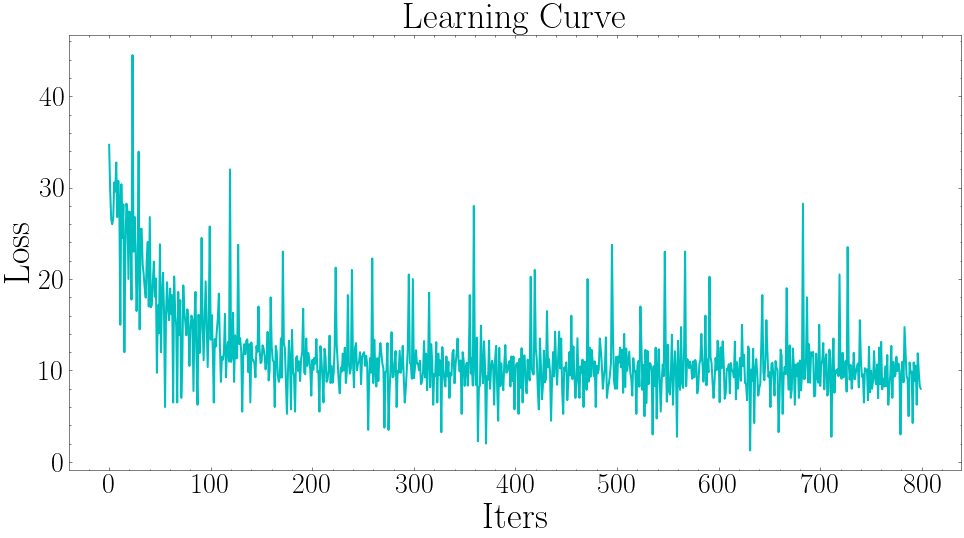

In [57]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28) 
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

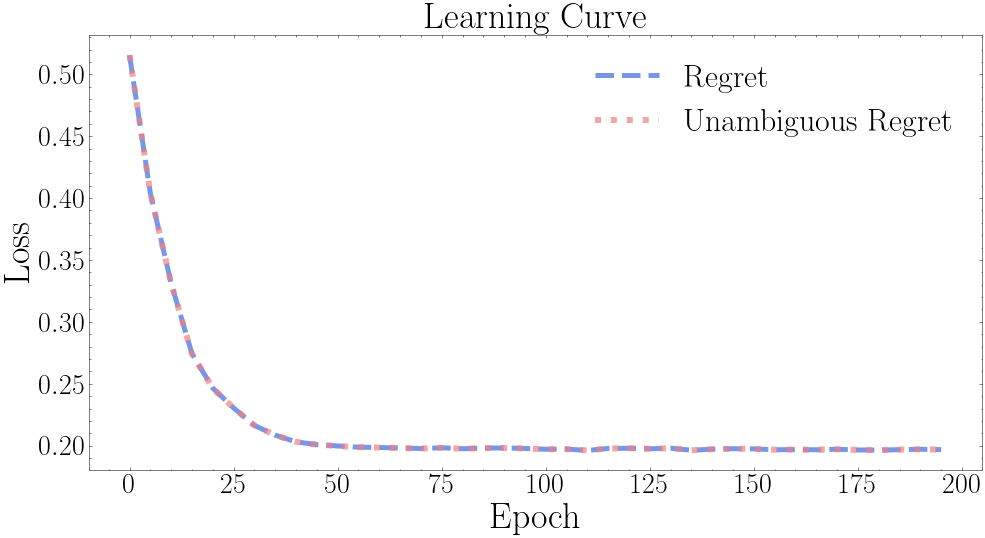

In [58]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [59]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 19.62%
Normalized Unambiguous Regret: 19.62%


In [60]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: -0.86, 16.30, -3.15, -0.15, -2.67, -1.04, -0.94, 1.30, -0.25, 1.61, 16.51, -1.31, -2.40, 16.32, 9.17, -2.31, 0.29, 0.49, 12.26, -0.49, -1.06, -1.08, -0.19, -7.00, -0.51, 13.74, 6.51, 10.85, -0.67, 0.75, 0.51, -1.10, 0.16, -0.15, -0.53, 17.53, -0.41, -0.53, -0.01, -0.50, 3.44, 0.09, -0.35, 0.65, 5.18, 4.42, 18.87, -1.21
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 